In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import numpy as np
import matplotlib.pyplot as plt

# Define the variables such as image_size and batch size and epochs and channel

In [3]:
IMAGE_SIZE=180
BATCH_SIZE=32
EPOCHS=10
CHANNEL=3

In [4]:
#Load the dataset
dataset=tf.keras.preprocessing.image_dataset_from_directory("../input/tomatodataplantvillage",shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                            batch_size=BATCH_SIZE)

Found 16011 files belonging to 10 classes.


2022-10-06 10:17:25.456341: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
#Print the class names
class_names=dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
for img_batch,label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())

2022-10-06 10:17:25.619785: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(32, 180, 180, 3)
[0 6 0 4 0 9 6 7 0 2 0 5 9 5 9 0 7 0 0 7 0 0 7 0 1 4 5 0 8 9 2 0]


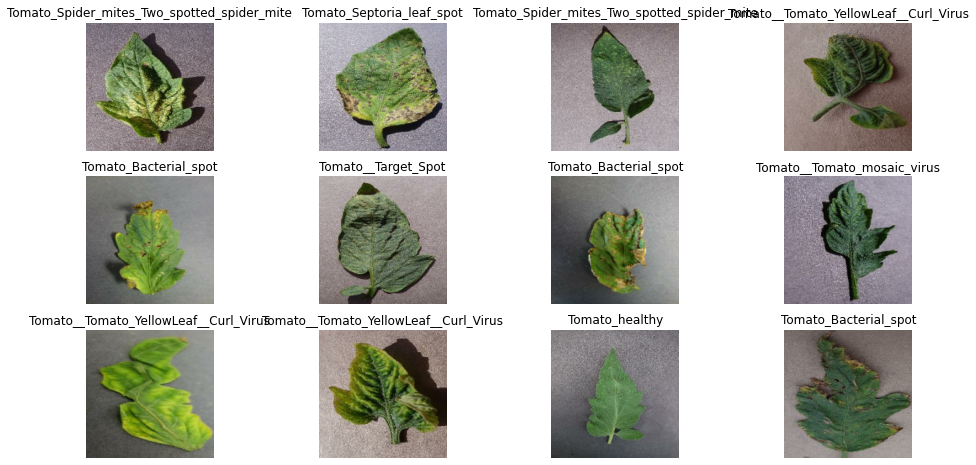

In [7]:
plt.figure(figsize=(16,8))
for img_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3, 4, i + 1)

        plt.imshow(img_batch[i].numpy().astype("uint8"))
        
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
def get_dataset_partition_df(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    if shuffle:
        shuffle_size=1000
        ds=ds.shuffle(shuffle_size,seed=12)
        
        train_size=int(train_split*ds_size)
        val_size=int(val_split*ds_size)
        train_ds=ds.take(train_size)
        val_ds=ds.skip(train_size).take(val_size)
        test_ds=ds.skip(train_size).skip(val_size)
        return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds=get_dataset_partition_df(dataset)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


# Modeling

In [11]:
#modeling
resize_and_rescale=tf.keras.Sequential([layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                    layers.experimental.preprocessing.Rescaling(1./255)])

In [12]:
data_augmentation=tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                    layers.experimental.preprocessing.RandomRotation(0.2)])

# Modeling

In [13]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

!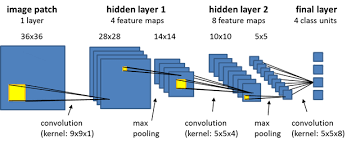[](http://)

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [15]:
#summary of the dataset
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 180, 180, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 178, 178, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 89, 89, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 87, 87, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 43, 43, 64)          0         
_________________________________________________________________
flatten (Flatten)            (32, 118336)              0         
_________________________________________________________________
dense (Dense)                (32, 64)                 

In [16]:
#complie the model with optimizer and loss and metric
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [17]:
#fit the model with train_ds and batch_size abd validatun set
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
    
)


Epoch 1/10


2022-10-06 10:17:39.093391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 154 of 1000
2022-10-06 10:17:49.138139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 315 of 1000
2022-10-06 10:17:59.100359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 475 of 1000
2022-10-06 10:18:00.405593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-10-06 10:18:00.405686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-10-06 10:18:00.405700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2 of 1000
2022-10-06 10:18:00.405711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 3 of 1000
202

400/400 [==============================] - ETA: 0s - loss: 1.1318 - accuracy: 0.6186

2022-10-06 10:21:32.930482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 287 of 1000
2022-10-06 10:21:42.267803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-10-06 10:21:42.270033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-10-06 10:21:42.270447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


400/400 [==============================] - 259s 567ms/step - loss: 1.1318 - accuracy: 0.6186 - val_loss: 1.1177 - val_accuracy: 0.6081
Epoch 2/10
400/400 [==============================] - 208s 520ms/step - loss: 0.5947 - accuracy: 0.7923 - val_loss: 0.7260 - val_accuracy: 0.7519
Epoch 3/10
400/400 [==============================] - 207s 517ms/step - loss: 0.4656 - accuracy: 0.8384 - val_loss: 0.5400 - val_accuracy: 0.7994
Epoch 4/10
400/400 [==============================] - 211s 526ms/step - loss: 0.4215 - accuracy: 0.8569 - val_loss: 0.4896 - val_accuracy: 0.8263
Epoch 5/10
400/400 [==============================] - 209s 522ms/step - loss: 0.3495 - accuracy: 0.8805 - val_loss: 0.6701 - val_accuracy: 0.7738
Epoch 6/10
400/400 [==============================] - 206s 515ms/step - loss: 0.3271 - accuracy: 0.8895 - val_loss: 0.4427 - val_accuracy: 0.8481
Epoch 7/10
400/400 [==============================] - 207s 518ms/step - loss: 0.3018 - accuracy: 0.8945 - val_loss: 0.3781 - val_accura

In [18]:
#Evaluate the model score
scores = model.evaluate(test_ds)
scores

2022-10-06 10:56:04.015411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 293 of 1000


 1/51 [..............................] - ETA: 12:36 - loss: 0.3388 - accuracy: 0.9062

2022-10-06 10:56:09.012364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-10-06 10:56:09.014098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-10-06 10:56:09.014469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


51/51 [==============================] - 20s 106ms/step - loss: 0.2608 - accuracy: 0.9105


[0.26084762811660767, 0.9105392098426819]

In [19]:
#Let's create the variable with loss and accuracy score
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

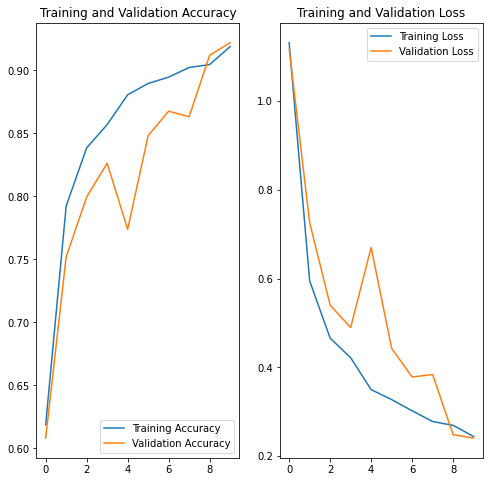

In [20]:
#To visualize the loss and accuracy score using the matplotlib
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Prediction of the images

first image to predict
actual label: Tomato__Tomato_YellowLeaf__Curl_Virus
predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus


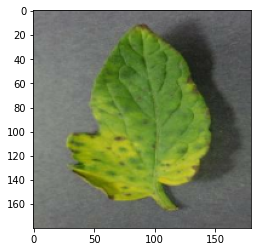

In [21]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


# Check the model evalution of the images

In [22]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


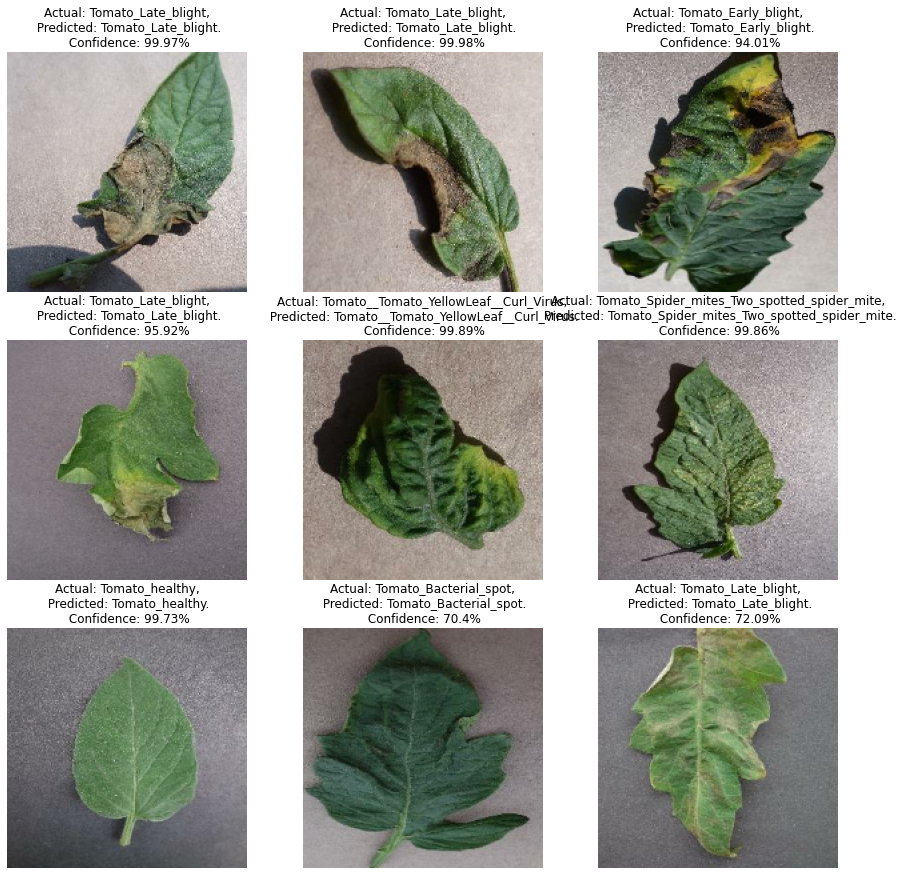

In [23]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [24]:
import os
model.save(f"..{model}")

2022-10-06 10:56:18.677560: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# And finaly save the model in the h5 model

In [25]:
model.save("Tomato disease1.h5")

In [26]:
model.save("Tomato disease1.hdf5")